## Regress out cell counts from all features

In [1]:
import sys
sys.path.append('../1.load')

import numpy as np
import pandas as pd

from preprocess import preprocess_profiles, config
from correct_position_effect import subtract_well_mean, mad_robustize_col, regress_out_cell_counts

import seaborn as sns
from matplotlib import pyplot as plt

#### Load a subset of profiles

In [2]:
CC_COL = "Cells_Count"

In [3]:
ann_profiles = pd.read_parquet("../1.load/output/subset_profiles.parquet")
ann_profiles

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_Variance_RNA_10_02_256,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256
0,JCP2022_900006,ccsbBroad304_00008,ORF000425.1_TRC304.1,pLX_304,NM_001095.4,ASIC1,41,9606,acid sensing ion channel subunit 1,100.0,...,49.558998,48.712002,46.077000,46.318001,46.028999,46.393002,46.639000,47.831001,46.651001,48.021000
1,JCP2022_900176,ccsbBroad304_00189,ORF011559.1_TRC304.1,pLX_304,NM_000587.4,C7,730,9606,complement C7,100.0,...,62.689999,61.765999,57.683998,58.122002,57.683998,58.137001,58.535999,60.215000,58.625999,60.560001
2,JCP2022_900198,ccsbBroad304_00212,ORF000189.1_TRC304.1,pLX_304,NM_001745.4,CAMLG,819,9606,calcium modulating ligand,100.0,...,43.979000,42.872002,40.491001,40.872002,40.462002,40.923000,41.264000,42.422001,41.236000,42.514000
3,JCP2022_900294,ccsbBroad304_00321,ORF012872.1_TRC304.1,pLX_304,NM_001830.4,CLCN4,1183,9606,chloride voltage-gated channel 4,100.0,...,53.324001,51.533001,49.242001,49.653000,49.251999,49.708000,50.063999,51.639999,50.113998,51.570000
4,JCP2022_900295,ccsbBroad304_00322,ORF012041.1_TRC304.1,pLX_304,NM_000084.5,CLCN5,1184,9606,chloride voltage-gated channel 5,100.0,...,56.792000,55.993000,52.728001,53.193001,52.875999,53.160000,53.438000,54.987999,53.695000,55.131001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19139,JCP2022_915130,ccsbBroad304_99991,ORFC00003.1_TRC304.1,pLX_304,promegaLuc.1,LUCIFERASE,LUCIFERASE,CONTROL,promegaLuc,100.0,...,30.912001,31.225000,28.951000,29.181999,29.153999,29.162001,29.171000,30.061001,29.388000,29.938000
19140,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,34.484001,34.605999,32.294998,32.636002,32.362000,32.466000,32.683998,33.604000,32.743999,33.476002
19141,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,31.149000,30.981001,28.872999,29.042000,28.905001,29.143999,29.282000,30.084999,29.292000,30.077000
19142,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,33.618999,33.861000,31.473000,31.583000,31.374001,31.563999,31.844000,32.480000,31.665001,32.480999


Text(0.059862097785206854, 5, '0.060')

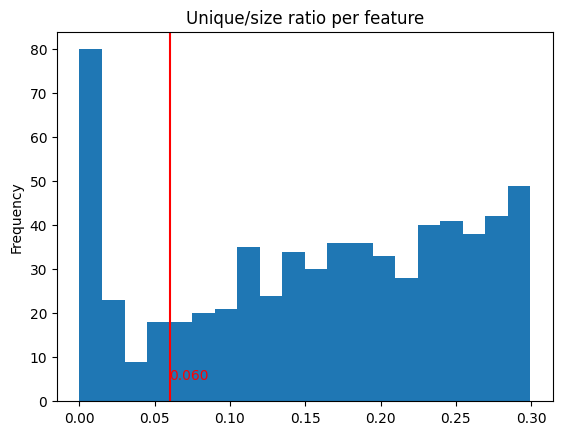

In [4]:
unique_ratio = ann_profiles.nunique() / ann_profiles.shape[0]
unique_ratio[unique_ratio<0.3].plot(kind="hist", bins=20, title="Unique/size ratio per feature (<0.3)")
plt.axvline(x=unique_ratio["Cells_Count"], color="red")
plt.text(unique_ratio["Cells_Count"], 5, f"{unique_ratio['Cells_Count']:.3f}", color="red")

#### Explore correlations with cell counts

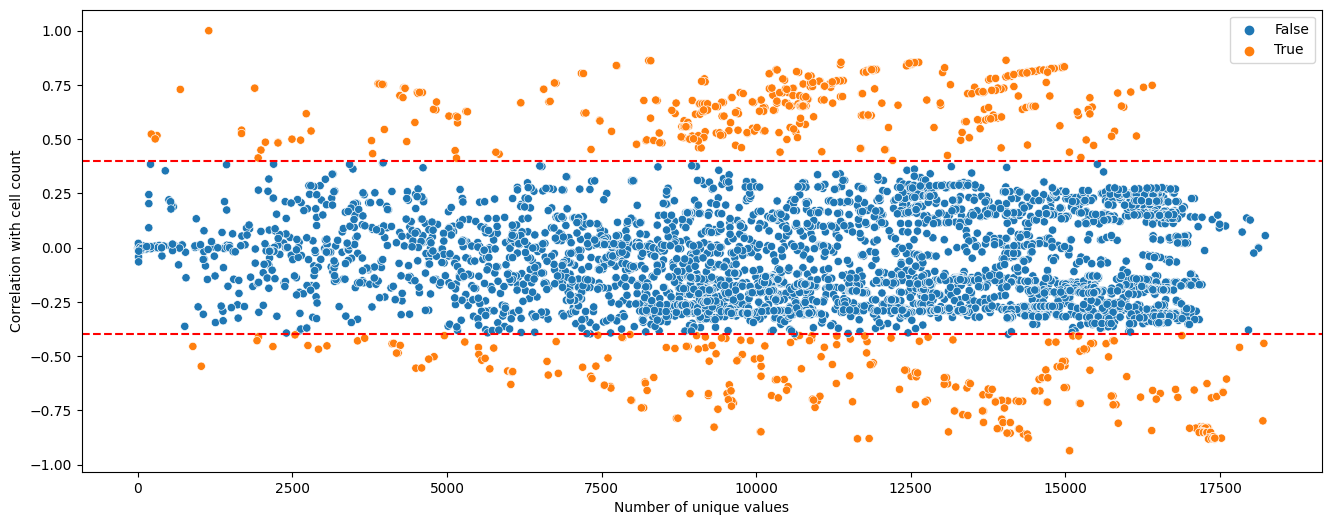

In [5]:
corr_cutoff = 0.4

plt.figure(figsize=(16, 6)) 
sns.scatterplot(
    data=ann_profiles.filter(regex="^(?!Metadata_)"),
    x=ann_profiles.filter(regex="^(?!Metadata_)").nunique(),
    y=ann_profiles.filter(regex="^(?!Metadata_)").corrwith(ann_profiles["Cells_Count"]),
    hue=ann_profiles.filter(regex="^(?!Metadata_)").corrwith(ann_profiles["Cells_Count"]).abs() > corr_cutoff,
    )
plt.xlabel("Number of unique values")
plt.ylabel("Correlation with cell count")


plt.axhline(y=corr_cutoff, color="red", linestyle="--")
plt.axhline(y=-corr_cutoff, color="red", linestyle="--")

plt.show()

In [6]:
for feature in ann_profiles.filter(regex="^(?!Metadata_)").columns:
    feature_corr = ann_profiles["Cells_Count"].corr(ann_profiles[feature])
    if (feature_corr > corr_cutoff or feature_corr < -corr_cutoff) and ann_profiles[feature].nunique() < 1000:
        print(f"{feature}: {ann_profiles.Cells_Count.corr(ann_profiles[feature])}")

Cytoplasm_RadialDistribution_MeanFrac_AGP_3of4: -0.45531803969044377
Image_Threshold_SumOfEntropies_CellsIncludingEdges: 0.7294216843129527
Nuclei_Correlation_Manders_AGP_RNA: 0.5167819100642198
Nuclei_Correlation_Manders_ER_RNA: 0.5235278607293792
Nuclei_Correlation_Manders_Mito_RNA: 0.5013644161374486


#### Histogram of unique values for feature columns with less than 100 unique values

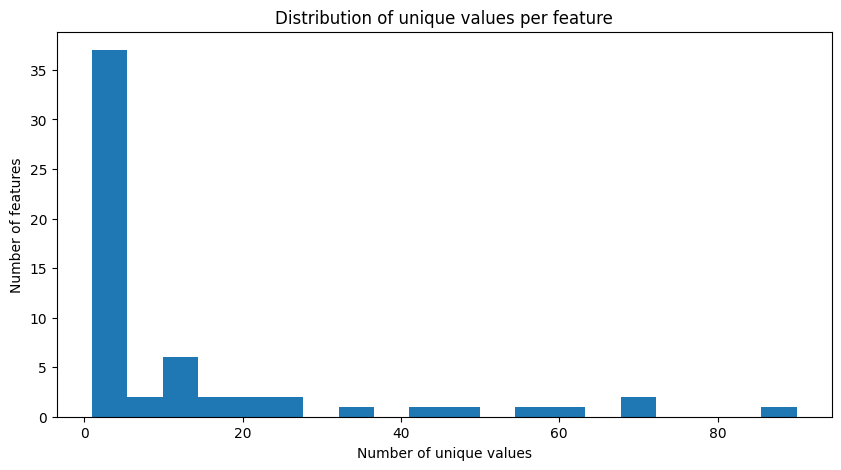

In [7]:
num_unique = ann_profiles.filter(regex="^(?!Metadata_)").nunique()

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(num_unique[num_unique < 100], bins=20)
ax.set_xlabel("Number of unique values")
ax.set_ylabel("Number of features")
ax.set_title("Distribution of unique values per feature (<100)")
plt.show()


#### Regress each feature on cell counts and store the residuals

In [8]:
ann_profiles = regress_out_cell_counts(ann_profiles, CC_COL)
ann_profiles

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_Variance_RNA_10_02_256,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256
0,JCP2022_900006,ccsbBroad304_00008,ORF000425.1_TRC304.1,pLX_304,NM_001095.4,ASIC1,41,9606,acid sensing ion channel subunit 1,100.0,...,-22.017839,-21.557611,-20.348539,-20.629281,-20.367806,-20.649965,-20.883736,-21.518449,-20.845304,-21.408078
1,JCP2022_900176,ccsbBroad304_00189,ORF011559.1_TRC304.1,pLX_304,NM_000587.4,C7,730,9606,complement C7,100.0,...,-5.385398,-5.082205,-5.480802,-5.539155,-5.454112,-5.611072,-5.670324,-5.736946,-5.556997,-5.461195
2,JCP2022_900198,ccsbBroad304_00212,ORF000189.1_TRC304.1,pLX_304,NM_001745.4,CAMLG,819,9606,calcium modulating ligand,100.0,...,-28.007580,-27.797989,-26.316114,-26.459826,-26.316141,-26.505539,-26.646827,-27.325030,-26.648032,-27.313873
3,JCP2022_900294,ccsbBroad304_00321,ORF012872.1_TRC304.1,pLX_304,NM_001830.4,CLCN4,1183,9606,chloride voltage-gated channel 4,100.0,...,-15.682629,-16.225152,-14.790017,-14.882126,-14.752785,-14.916374,-15.024349,-15.215539,-14.950197,-15.357548
4,JCP2022_900295,ccsbBroad304_00322,ORF012041.1_TRC304.1,pLX_304,NM_000084.5,CLCN5,1184,9606,chloride voltage-gated channel 5,100.0,...,-17.727537,-17.152052,-16.437947,-16.516024,-16.259498,-16.652079,-16.871934,-17.216801,-16.585894,-17.162148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19139,JCP2022_915130,ccsbBroad304_99991,ORFC00003.1_TRC304.1,pLX_304,promegaLuc.1,LUCIFERASE,LUCIFERASE,CONTROL,promegaLuc,100.0,...,-44.985763,-43.266776,-41.498430,-41.820501,-41.264176,-41.947005,-42.444331,-43.481114,-42.197068,-43.696549
19140,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-35.155869,-33.770919,-32.326728,-32.493423,-32.232123,-32.754260,-33.004127,-33.865980,-32.919411,-34.067865
19141,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-40.316089,-39.179418,-37.448474,-37.800405,-37.387804,-37.793811,-38.134894,-39.156020,-38.098561,-39.243316
19142,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-36.914855,-35.389470,-33.981255,-34.385436,-34.052130,-34.497510,-34.690869,-35.857428,-34.844361,-35.932965


#### Check if cell count has correlation above 0.5 with any feature

In [9]:
for feature in ann_profiles.filter(regex="^(?!Metadata_)").columns:
    feature_corr = ann_profiles["Cells_Count"].corr(ann_profiles[feature])
    if feature_corr > 0.5:
        print(f"{feature}: {ann_profiles.Cells_Count.corr(ann_profiles[feature])}")

Cells_Count: 1.0


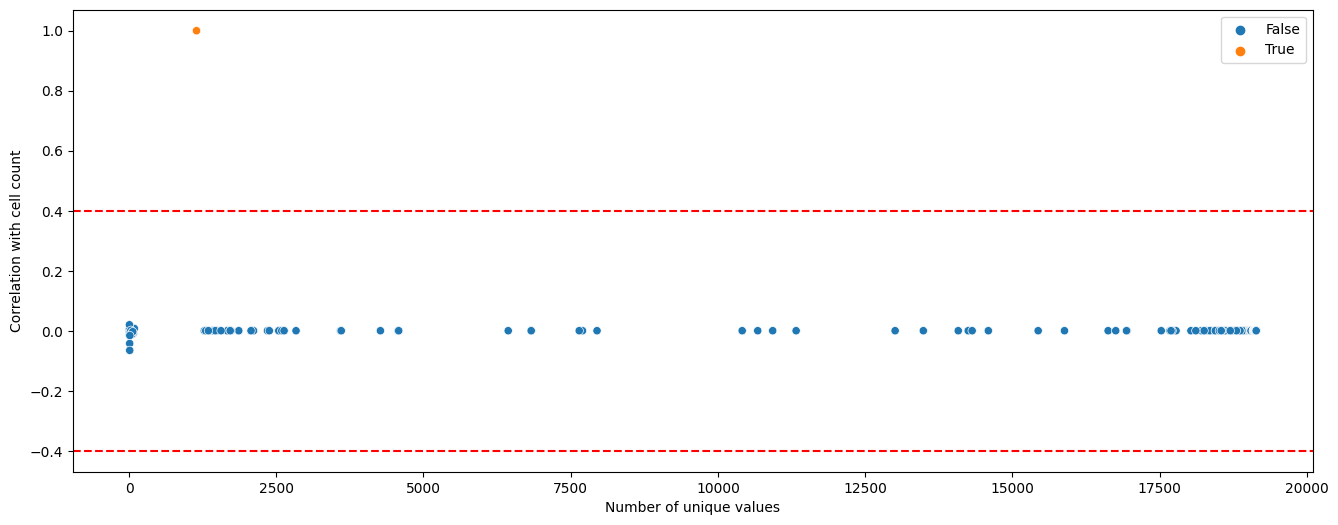

In [10]:
corr_cutoff = 0.4

plt.figure(figsize=(16, 6)) 
sns.scatterplot(
    data=ann_profiles.filter(regex="^(?!Metadata_)"),
    x=ann_profiles.filter(regex="^(?!Metadata_)").nunique(),
    y=ann_profiles.filter(regex="^(?!Metadata_)").corrwith(ann_profiles["Cells_Count"]),
    hue=ann_profiles.filter(regex="^(?!Metadata_)").corrwith(ann_profiles["Cells_Count"]).abs() > corr_cutoff,
    )
plt.xlabel("Number of unique values")
plt.ylabel("Correlation with cell count")


plt.axhline(y=corr_cutoff, color="red", linestyle="--")
plt.axhline(y=-corr_cutoff, color="red", linestyle="--")

plt.show()

#### Plot the ratio of unique values / size for cell count

This is the reason it gets filtered by `feature_select`

Text(0.059862097785206854, 5, '0.060')

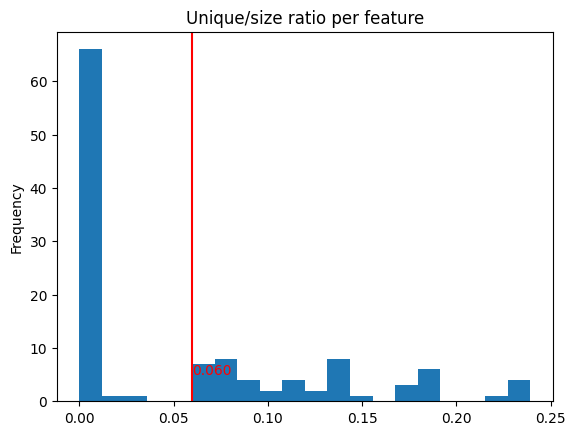

In [11]:
unique_ratio = ann_profiles.nunique() / ann_profiles.shape[0]
unique_ratio[unique_ratio<0.3].plot(kind="hist", bins=20, title="Unique/size ratio per feature")
plt.axvline(x=unique_ratio["Cells_Count"], color="red")
plt.text(unique_ratio["Cells_Count"], 5, f"{unique_ratio['Cells_Count']:.3f}", color="red")

#### Preprocess and save CC-corrected subset

In [12]:
ann_profiles_processed = preprocess_profiles(ann_profiles) 
ann_profiles_processed

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_InfoMeas1_AGP_5_01_256,Nuclei_Texture_InfoMeas1_AGP_5_02_256,Nuclei_Texture_InfoMeas1_DNA_3_00_256,Nuclei_Texture_InfoMeas1_ER_3_00_256,Nuclei_Texture_InfoMeas1_Mito_3_03_256,Nuclei_Texture_InfoMeas1_Mito_5_03_256,Nuclei_Texture_InfoMeas1_RNA_3_00_256,Nuclei_Texture_InfoMeas2_AGP_3_00_256,Nuclei_Texture_InfoMeas2_ER_3_00_256,Nuclei_Texture_InfoMeas2_Mito_3_00_256
0,JCP2022_900006,ccsbBroad304_00008,ORF000425.1_TRC304.1,pLX_304,NM_001095.4,ASIC1,41,9606,acid sensing ion channel subunit 1,100.0,...,0.843520,0.076629,0.320495,-0.385691,0.190393,0.455439,0.509989,-1.019058,-0.728018,-0.842900
1,JCP2022_900176,ccsbBroad304_00189,ORF011559.1_TRC304.1,pLX_304,NM_000587.4,C7,730,9606,complement C7,100.0,...,-0.553290,-1.089465,-0.339287,-1.516528,-0.441853,-0.130403,-0.575900,0.593813,0.509472,-0.214630
2,JCP2022_900198,ccsbBroad304_00212,ORF000189.1_TRC304.1,pLX_304,NM_001745.4,CAMLG,819,9606,calcium modulating ligand,100.0,...,-0.234758,-0.754398,0.077711,-0.322006,0.405521,0.628356,0.367091,0.264900,-0.726229,-0.754226
3,JCP2022_900294,ccsbBroad304_00321,ORF012872.1_TRC304.1,pLX_304,NM_001830.4,CLCN4,1183,9606,chloride voltage-gated channel 4,100.0,...,0.015575,-0.494212,-0.287738,-0.628006,-0.710360,-0.637044,-0.199234,-0.135215,-0.290255,0.329603
4,JCP2022_900295,ccsbBroad304_00322,ORF012041.1_TRC304.1,pLX_304,NM_000084.5,CLCN5,1184,9606,chloride voltage-gated channel 5,100.0,...,-0.037950,-0.722263,-0.448482,-1.166396,-1.939791,-1.753126,-0.387831,-0.074344,0.047114,1.303154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19139,JCP2022_915130,ccsbBroad304_99991,ORFC00003.1_TRC304.1,pLX_304,promegaLuc.1,LUCIFERASE,LUCIFERASE,CONTROL,promegaLuc,100.0,...,-2.711637,-3.969020,-0.809173,-2.974404,-2.787182,-0.704466,0.198940,2.073704,0.223352,-0.531671
19140,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-2.077464,-3.094050,-0.711135,-2.103393,-1.919127,-0.485729,0.300176,1.795613,-0.029494,-0.503798
19141,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-2.488416,-3.648240,-0.653903,-2.628677,-2.837781,-0.915236,0.115573,2.372484,0.350838,0.082462
19142,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-2.967861,-4.202986,-0.806160,-2.797058,-2.398970,-0.965612,0.605841,2.384358,0.194635,0.017635


In [13]:
# check that the cell count column is still there
assert CC_COL in ann_profiles_processed.columns

ann_profiles_processed.to_parquet("output/subset_profiles_cc_corrected.parquet")
del ann_profiles_processed

#### Apply well mean subtraction, preprocess and save

In [14]:
ann_profiles = subtract_well_mean(ann_profiles)
ann_profiles = preprocess_profiles(ann_profiles)
ann_profiles.to_parquet("output/subset_profiles_cc_well_corrected.parquet")
ann_profiles

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_InfoMeas1_AGP_5_01_256,Nuclei_Texture_InfoMeas1_AGP_5_02_256,Nuclei_Texture_InfoMeas1_DNA_3_00_256,Nuclei_Texture_InfoMeas1_ER_3_00_256,Nuclei_Texture_InfoMeas1_Mito_3_03_256,Nuclei_Texture_InfoMeas1_Mito_5_03_256,Nuclei_Texture_InfoMeas1_RNA_3_00_256,Nuclei_Texture_InfoMeas2_AGP_3_00_256,Nuclei_Texture_InfoMeas2_ER_3_00_256,Nuclei_Texture_SumVariance_AGP_5_01_256
0,JCP2022_900006,ccsbBroad304_00008,ORF000425.1_TRC304.1,pLX_304,NM_001095.4,ASIC1,41,9606,acid sensing ion channel subunit 1,100.0,...,0.741315,0.112042,0.722820,-0.542878,0.445819,0.554633,0.000246,-0.777673,-0.271556,-0.301070
1,JCP2022_900176,ccsbBroad304_00189,ORF011559.1_TRC304.1,pLX_304,NM_000587.4,C7,730,9606,complement C7,100.0,...,-0.344151,-0.859927,-0.216504,-1.635898,-0.594053,-0.245424,-0.384197,0.320188,0.534347,-0.265611
2,JCP2022_900198,ccsbBroad304_00212,ORF000189.1_TRC304.1,pLX_304,NM_001745.4,CAMLG,819,9606,calcium modulating ligand,100.0,...,-0.052188,-0.284880,0.654772,-0.385083,0.738852,0.778439,0.157445,0.227132,-0.378389,-0.490796
3,JCP2022_900294,ccsbBroad304_00321,ORF012872.1_TRC304.1,pLX_304,NM_001830.4,CLCN4,1183,9606,chloride voltage-gated channel 4,100.0,...,0.024454,-0.186934,-0.008743,-0.695323,-0.444192,-0.444712,-0.123820,-0.066552,-0.135714,-0.355337
4,JCP2022_900295,ccsbBroad304_00322,ORF012041.1_TRC304.1,pLX_304,NM_000084.5,CLCN5,1184,9606,chloride voltage-gated channel 5,100.0,...,-0.032457,-0.443297,0.014899,-1.215245,-1.526079,-1.410069,-0.958717,-0.034017,0.286270,-0.107739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19139,JCP2022_915130,ccsbBroad304_99991,ORFC00003.1_TRC304.1,pLX_304,promegaLuc.1,LUCIFERASE,LUCIFERASE,CONTROL,promegaLuc,100.0,...,-2.495777,-3.650269,-0.848690,-2.937236,-2.436438,-0.436381,0.461984,2.106191,0.340590,-0.859667
19140,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-1.888192,-2.749796,-0.259789,-2.186415,-1.711162,-0.142883,0.290334,1.651752,-0.077586,-0.304493
19141,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-2.662716,-3.759512,-0.895225,-2.655379,-3.027403,-1.034180,0.781016,2.484165,0.176254,-0.158996
19142,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-3.469905,-4.787423,-1.019240,-3.183991,-3.002272,-1.290461,1.253938,2.805805,0.129172,-0.161503


#### Regress out cell count from the preprocessed subset

In [15]:
ann_profiles = pd.read_parquet("../1.load/output/subset_processed_profiles.parquet")
ann_profiles

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_InfoMeas1_AGP_5_02_256,Nuclei_Texture_InfoMeas1_DNA_3_00_256,Nuclei_Texture_InfoMeas1_ER_3_00_256,Nuclei_Texture_InfoMeas1_ER_3_03_256,Nuclei_Texture_InfoMeas1_Mito_3_03_256,Nuclei_Texture_InfoMeas1_Mito_5_03_256,Nuclei_Texture_InfoMeas1_RNA_3_00_256,Nuclei_Texture_InfoMeas2_AGP_3_00_256,Nuclei_Texture_InfoMeas2_ER_3_00_256,Nuclei_Texture_InfoMeas2_Mito_3_00_256
0,JCP2022_900006,ccsbBroad304_00008,ORF000425.1_TRC304.1,pLX_304,NM_001095.4,ASIC1,41,9606,acid sensing ion channel subunit 1,100.0,...,0.128693,0.473209,-0.347879,0.571561,0.233940,0.605959,0.578546,-1.184907,-0.876162,-1.057291
1,JCP2022_900176,ccsbBroad304_00189,ORF011559.1_TRC304.1,pLX_304,NM_000587.4,C7,730,9606,complement C7,100.0,...,-0.980136,-0.033869,-1.433294,-0.133203,-0.359655,0.173131,-0.434340,0.301239,0.198563,-0.642222
2,JCP2022_900198,ccsbBroad304_00212,ORF000189.1_TRC304.1,pLX_304,NM_001745.4,CAMLG,819,9606,calcium modulating ligand,100.0,...,-0.702068,0.220961,-0.288633,0.636346,0.443830,0.758651,0.430319,0.111316,-0.859052,-0.949307
3,JCP2022_900294,ccsbBroad304_00321,ORF012872.1_TRC304.1,pLX_304,NM_001830.4,CLCN4,1183,9606,chloride voltage-gated channel 4,100.0,...,-0.402167,-0.019677,-0.564355,0.445624,-0.636230,-0.359488,-0.078135,-0.393562,-0.545916,-0.066014
4,JCP2022_900295,ccsbBroad304_00322,ORF012041.1_TRC304.1,pLX_304,NM_000084.5,CLCN5,1184,9606,chloride voltage-gated channel 5,100.0,...,-0.705514,-0.389340,-1.144660,-0.064180,-1.915246,-1.671197,-0.359077,-0.137696,-0.010367,1.174983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19138,JCP2022_915130,ccsbBroad304_99991,ORFC00003.1_TRC304.1,pLX_304,promegaLuc.1,LUCIFERASE,LUCIFERASE,CONTROL,promegaLuc,100.0,...,-3.948126,-0.793841,-2.941786,-1.063807,-2.772297,-0.700941,0.197062,2.055386,0.213081,-0.520736
19139,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-2.992120,-0.456435,-2.026512,-0.405664,-1.845284,-0.236853,0.404465,1.556313,-0.268032,-0.835836
19140,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-3.567792,-0.471273,-2.561244,-0.951796,-2.777763,-0.729796,0.190742,2.196773,0.171086,-0.170204
19141,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-4.105547,-0.583526,-2.719235,-1.129803,-2.331747,-0.741819,0.691152,2.175670,-0.016072,-0.283672


In [16]:
ann_profiles = regress_out_cell_counts(ann_profiles, CC_COL)
ann_profiles

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_InfoMeas1_AGP_5_02_256,Nuclei_Texture_InfoMeas1_DNA_3_00_256,Nuclei_Texture_InfoMeas1_ER_3_00_256,Nuclei_Texture_InfoMeas1_ER_3_03_256,Nuclei_Texture_InfoMeas1_Mito_3_03_256,Nuclei_Texture_InfoMeas1_Mito_5_03_256,Nuclei_Texture_InfoMeas1_RNA_3_00_256,Nuclei_Texture_InfoMeas2_AGP_3_00_256,Nuclei_Texture_InfoMeas2_ER_3_00_256,Nuclei_Texture_InfoMeas2_Mito_3_00_256
0,JCP2022_900006,ccsbBroad304_00008,ORF000425.1_TRC304.1,pLX_304,NM_001095.4,ASIC1,41,9606,acid sensing ion channel subunit 1,100.0,...,0.185587,0.380373,-0.338434,0.434018,0.316296,0.449249,0.467342,-0.806398,-0.419014,-0.599807
1,JCP2022_900176,ccsbBroad304_00189,ORF011559.1_TRC304.1,pLX_304,NM_000587.4,C7,730,9606,complement C7,100.0,...,-0.972070,-0.262062,-1.454826,-0.374529,-0.312747,-0.123587,-0.605621,0.803648,0.787039,0.006647
2,JCP2022_900198,ccsbBroad304_00212,ORF000189.1_TRC304.1,pLX_304,NM_001745.4,CAMLG,819,9606,calcium modulating ligand,100.0,...,-0.639460,0.143964,-0.275563,0.510948,0.530334,0.618325,0.326145,0.475325,-0.417272,-0.514219
3,JCP2022_900294,ccsbBroad304_00321,ORF012872.1_TRC304.1,pLX_304,NM_001830.4,CLCN4,1183,9606,chloride voltage-gated channel 4,100.0,...,-0.381114,-0.211870,-0.577648,0.231900,-0.579894,-0.618970,-0.233438,0.075895,0.007632,0.531955
4,JCP2022_900295,ccsbBroad304_00322,ORF012041.1_TRC304.1,pLX_304,NM_000084.5,CLCN5,1184,9606,chloride voltage-gated channel 5,100.0,...,-0.607584,-0.368419,-1.109182,-0.114502,-1.803099,-1.710241,-0.419790,0.136683,0.336410,1.471622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19138,JCP2022_915130,ccsbBroad304_99991,ORFC00003.1_TRC304.1,pLX_304,promegaLuc.1,LUCIFERASE,LUCIFERASE,CONTROL,promegaLuc,100.0,...,-3.830976,-0.719642,-2.894114,-1.073278,-2.646198,-0.684874,0.159997,2.280996,0.508166,-0.299430
19139,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-2.962237,-0.624149,-2.034203,-0.600619,-1.782537,-0.471014,0.260027,2.003362,0.261765,-0.272480
19140,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-3.512456,-0.568429,-2.552787,-1.092651,-2.696538,-0.890974,0.077621,2.579236,0.632425,0.293387
19141,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-4.063197,-0.716682,-2.719017,-1.298260,-2.259950,-0.940233,0.562053,2.591085,0.480195,0.230820


In [17]:
ann_profiles[CC_COL] = mad_robustize_col(ann_profiles[CC_COL], epsilon=config["MAD_EPSILON"])

In [18]:
ann_profiles.to_parquet("output/subset_processed_cc_corrected.parquet")

#### Regress out cell count from the preprocessed and corrected dataset

In [19]:
ann_profiles = pd.read_parquet("output/subset_profiles_mean_corrected_preprocessed.parquet")
ann_profiles

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_InfoMeas1_AGP_5_01_256,Nuclei_Texture_InfoMeas1_AGP_5_02_256,Nuclei_Texture_InfoMeas1_DNA_3_00_256,Nuclei_Texture_InfoMeas1_ER_3_00_256,Nuclei_Texture_InfoMeas1_Mito_3_03_256,Nuclei_Texture_InfoMeas1_Mito_5_03_256,Nuclei_Texture_InfoMeas1_RNA_3_00_256,Nuclei_Texture_InfoMeas2_AGP_3_00_256,Nuclei_Texture_InfoMeas2_ER_3_00_256,Nuclei_Texture_InfoMeas2_Mito_3_00_256
0,JCP2022_900006,ccsbBroad304_00008,ORF000425.1_TRC304.1,pLX_304,NM_001095.4,ASIC1,41,9606,acid sensing ion channel subunit 1,100.0,...,0.798157,0.146819,0.819576,-0.509169,0.472318,0.642681,0.066633,-0.881860,-0.350066,-1.073529
1,JCP2022_900176,ccsbBroad304_00189,ORF011559.1_TRC304.1,pLX_304,NM_000587.4,C7,730,9606,complement C7,100.0,...,-0.008716,-0.727536,0.174183,-1.533901,-0.491498,0.133856,-0.166967,-0.046219,0.143956,-0.708162
2,JCP2022_900198,ccsbBroad304_00212,ORF000189.1_TRC304.1,pLX_304,NM_001745.4,CAMLG,819,9606,calcium modulating ligand,100.0,...,0.092668,-0.227209,0.816750,-0.338482,0.779559,0.923186,0.256518,0.053587,-0.516253,-1.248180
3,JCP2022_900294,ccsbBroad304_00321,ORF012872.1_TRC304.1,pLX_304,NM_001830.4,CLCN4,1183,9606,chloride voltage-gated channel 4,100.0,...,0.276906,-0.083525,0.298071,-0.617495,-0.362687,-0.138488,0.048434,-0.356286,-0.416854,-0.335360
4,JCP2022_900295,ccsbBroad304_00322,ORF012041.1_TRC304.1,pLX_304,NM_000084.5,CLCN5,1184,9606,chloride voltage-gated channel 5,100.0,...,0.042108,-0.414073,0.105622,-1.180956,-1.491862,-1.289506,-0.893941,-0.129673,0.202546,0.657406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19139,JCP2022_915130,ccsbBroad304_99991,ORFC00003.1_TRC304.1,pLX_304,promegaLuc.1,LUCIFERASE,LUCIFERASE,CONTROL,promegaLuc,100.0,...,-2.129139,-3.538451,-0.520974,-2.842374,-2.340930,-0.125043,0.631924,1.786284,0.033267,-0.950689
19140,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-1.647278,-2.680781,-0.061632,-2.122849,-1.650066,0.044767,0.398538,1.444183,-0.247909,-1.030216
19141,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-2.226537,-3.621706,-0.492188,-2.546204,-2.909455,-0.634502,0.987795,2.092715,-0.198424,-0.264739
19142,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-3.100481,-4.689853,-0.735725,-3.097747,-2.915065,-1.003161,1.391602,2.520438,-0.121587,-0.152909


In [20]:
ann_profiles = regress_out_cell_counts(ann_profiles, CC_COL)
ann_profiles

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_InfoMeas1_AGP_5_01_256,Nuclei_Texture_InfoMeas1_AGP_5_02_256,Nuclei_Texture_InfoMeas1_DNA_3_00_256,Nuclei_Texture_InfoMeas1_ER_3_00_256,Nuclei_Texture_InfoMeas1_Mito_3_03_256,Nuclei_Texture_InfoMeas1_Mito_5_03_256,Nuclei_Texture_InfoMeas1_RNA_3_00_256,Nuclei_Texture_InfoMeas2_AGP_3_00_256,Nuclei_Texture_InfoMeas2_ER_3_00_256,Nuclei_Texture_InfoMeas2_Mito_3_00_256
0,JCP2022_900006,ccsbBroad304_00008,ORF000425.1_TRC304.1,pLX_304,NM_001095.4,ASIC1,41,9606,acid sensing ion channel subunit 1,100.0,...,0.677520,0.217404,0.758719,-0.499869,0.599279,0.535746,-0.258093,-0.508333,0.138216,-0.680849
1,JCP2022_900176,ccsbBroad304_00189,ORF011559.1_TRC304.1,pLX_304,NM_000587.4,C7,730,9606,complement C7,100.0,...,-0.408756,-0.751360,-0.212706,-1.621886,-0.399497,-0.254634,-0.698628,0.642478,0.986948,0.096765
2,JCP2022_900198,ccsbBroad304_00212,ORF000189.1_TRC304.1,pLX_304,NM_001745.4,CAMLG,819,9606,calcium modulating ligand,100.0,...,-0.092574,-0.178453,0.680507,-0.351677,0.898436,0.751148,-0.116056,0.499989,0.054047,-0.760179
3,JCP2022_900294,ccsbBroad304_00321,ORF012872.1_TRC304.1,pLX_304,NM_001830.4,CLCN4,1183,9606,chloride voltage-gated channel 4,100.0,...,-0.042288,-0.080032,0.005520,-0.677331,-0.260570,-0.445510,-0.423350,0.241217,0.323502,0.350283
4,JCP2022_900295,ccsbBroad304_00322,ORF012041.1_TRC304.1,pLX_304,NM_000084.5,CLCN5,1184,9606,chloride voltage-gated channel 5,100.0,...,-0.059288,-0.336985,0.067218,-1.164956,-1.362493,-1.377051,-1.204415,0.222149,0.666400,1.021696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19139,JCP2022_915130,ccsbBroad304_99991,ORFC00003.1_TRC304.1,pLX_304,promegaLuc.1,LUCIFERASE,LUCIFERASE,CONTROL,promegaLuc,100.0,...,-2.453839,-3.536818,-0.819951,-2.904128,-2.239503,-0.437613,0.156061,2.389998,0.780614,-0.256921
19140,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-1.852071,-2.638632,-0.220690,-2.142851,-1.533635,-0.146973,0.011484,1.912640,0.347212,-0.513367
19141,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-2.626442,-3.645484,-0.878921,-2.634144,-2.817438,-1.022856,0.456233,2.781262,0.644398,0.539991
19142,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-3.377376,-4.672067,-0.978918,-3.142855,-2.807656,-1.267558,0.951146,3.070227,0.565069,0.470324


In [21]:
ann_profiles[CC_COL] = mad_robustize_col(ann_profiles[CC_COL], epsilon=config["MAD_EPSILON"])

In [22]:
ann_profiles.to_parquet("output/subset_mean_corrected_processed_cc_corrected.parquet")